In [14]:
import pandas as pd
import numpy as np
from configparser import ConfigParser
from sqlalchemy import create_engine

In [15]:
def config(filename='database.ini', section='postgresql'):
    # create a parser
    parser = ConfigParser()
    # read config file
    parser.read(filename)

    # get section, default to postgresql
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))

    return db

In [16]:
param_dic=config()

connect = "postgresql+psycopg2://%s:%s@%s:%s/%s" % (
param_dic['user'],
param_dic['password'],
param_dic['host'],
param_dic['port'],
param_dic['database']
)

engine=create_engine(connect, echo=False)

connection = engine.connect()

In [17]:
my_query= "select timestamp,close,high,low,open,trades,turnover,volume,vwap from bitmex as bt where  bt.timestamp >= date '2018-01-01' "

In [20]:
data= connection.execute(my_query).fetchall()

In [21]:
df=pd.DataFrame(data,columns=['timestamp','close','high','low','open','trades','turnover','volume','vwap'])


In [22]:
df.shape

(1489997, 9)

In [23]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1489997 entries, 0 to 1489996
Data columns (total 9 columns):
timestamp    1489997 non-null datetime64[ns, psycopg2.tz.FixedOffsetTimezone(offset=300, name=None)]
close        1489997 non-null float64
high         1489997 non-null float64
low          1489997 non-null float64
open         1489997 non-null float64
trades       1489997 non-null int64
turnover     1489997 non-null int64
volume       1489997 non-null int64
vwap         1489671 non-null float64
dtypes: datetime64[ns, psycopg2.tz.FixedOffsetTimezone(offset=300, name=None)](1), float64(5), int64(3)
memory usage: 102.3 MB


In [24]:
df.head()

,timestamp,close,high,low,open,trades,turnover,volume,vwap
0,2018-01-01 00:00:00+05:00,13925.5,13925.5,13892.5,13909.5,93,934907830,129990,13904.3
1,2018-01-01 00:01:00+05:00,13914.0,13938.5,13910.0,13925.5,143,3584829106,499411,13931.5
2,2018-01-01 00:02:00+05:00,13960.5,13979.5,13914.0,13914.0,196,2916432935,406988,13956.7
3,2018-01-01 00:03:00+05:00,13972.0,13972.0,13950.0,13960.5,76,862372954,120404,13962.6
4,2018-01-01 00:04:00+05:00,14010.5,14011.0,13968.5,13972.0,168,4861884435,680351,13993.8


In [25]:
df['date']=df['timestamp'].dt.date

In [26]:
df=df.groupby('date').mean()

In [27]:
df.head()

,close,high,low,open,trades,turnover,volume,vwap
date,,,,,,,,
2018-01-01,13541.366319,13557.984028,13524.845139,13541.872917,151.901389,3.191650e+09,430376.524306,13542.399306
2018-01-02,13618.049306,13632.106597,13602.637153,13616.986458,173.356250,3.991163e+09,547527.584028,13618.215833
2018-01-03,14993.412500,15009.243750,14977.330556,14993.340278,188.893056,4.238429e+09,635719.903472,14994.467292
2018-01-04,14846.844444,14859.795139,14833.456944,14846.855556,158.861806,3.806899e+09,564605.880556,14847.653750
2018-01-05,15463.361806,15476.509722,15449.327083,15462.259028,164.459028,3.995719e+09,624329.748611,15464.094653


In [28]:
df['vwap'].replace(0, np.nan, inplace=True)
df['vwap'].fillna(method='ffill', inplace=True)

In [70]:
from sklearn.preprocessing import MinMaxScaler
values = df['vwap'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [71]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

707 303


In [72]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [73]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

706
302


In [74]:
trainX.shape[1]

1

In [75]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [76]:
trainY

array([0.7717697 , 0.87351507, 0.8626612 , 0.9082342 , 0.99427384,
       0.99999994, 0.91851264, 0.86933035, 0.81818396, 0.7963609 ,
       0.76850384, 0.8110196 , 0.7867896 , 0.7819558 , 0.7016512 ,
       0.55962354, 0.6021012 , 0.6191176 , 0.66265965, 0.66453993,
       0.598735  , 0.5480312 , 0.5756601 , 0.59824336, 0.582196  ,
       0.58724123, 0.62214243, 0.60159284, 0.5661666 , 0.50315404,
       0.48349887, 0.4020412 , 0.41386676, 0.4260226 , 0.34574246,
       0.25856543, 0.34222662, 0.3679105 , 0.36932164, 0.40713954,
       0.37217212, 0.39431942, 0.40468192, 0.42088985, 0.47783166,
       0.5051595 , 0.54243463, 0.560868  , 0.56163144, 0.60820365,
       0.5799638 , 0.53144276, 0.5028236 , 0.5055731 , 0.47393763,
       0.48570108, 0.53926   , 0.55307066, 0.5461171 , 0.57637054,
       0.59810567, 0.5964902 , 0.6143026 , 0.59422493, 0.5467018 ,
       0.4894656 , 0.4281487 , 0.44883806, 0.4236722 , 0.47124773,
       0.43994445, 0.42596072, 0.36335772, 0.37524176, 0.37088

In [80]:
from keras.models import Sequential
from keras.layers import Activation, Dense,Dropout
from keras.layers import LSTM,GRU
model = Sequential()
#model.add(LSTM(256, input_shape=(trainX.shape[1], trainX.shape[2])))
#model.add(Dense(1))
model.add(LSTM(256, return_sequences=True,input_shape=(trainX.shape[1], trainX.shape[2])))

model.add(LSTM(256))


model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

In [81]:
import matplotlib.pyplot as plt

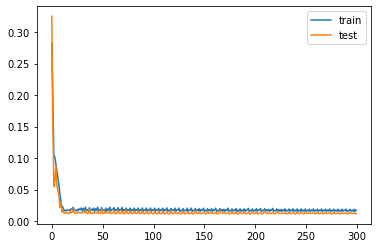

In [82]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

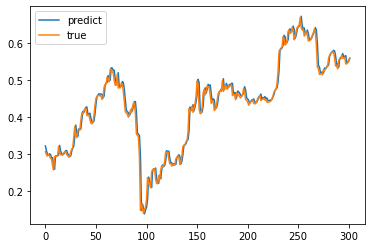

In [83]:
yhat = model.predict(testX)
plt.plot(yhat, label='predict')
plt.plot(testY, label='true')
plt.legend()
plt.show()

In [84]:
yhat.reshape(-1,1)

array([[0.3219281 ],
       [0.30901977],
       [0.30071762],
       [0.29698333],
       [0.30079827],
       [0.29926106],
       [0.29059216],
       [0.29054537],
       [0.272622  ],
       [0.25912994],
       [0.29505187],
       [0.29512787],
       [0.29633015],
       [0.29719648],
       [0.3235667 ],
       [0.3087092 ],
       [0.30071002],
       [0.30075797],
       [0.29938772],
       [0.30555728],
       [0.30916414],
       [0.30979154],
       [0.30094364],
       [0.29871997],
       [0.29387948],
       [0.29528764],
       [0.30838105],
       [0.31602502],
       [0.3211088 ],
       [0.34695792],
       [0.37856945],
       [0.35491648],
       [0.34781244],
       [0.3678878 ],
       [0.36804897],
       [0.3678482 ],
       [0.39324996],
       [0.4152582 ],
       [0.41224983],
       [0.42086834],
       [0.42668667],
       [0.42737263],
       [0.40839335],
       [0.40808   ],
       [0.41061276],
       [0.39716917],
       [0.387206  ],
       [0.385

In [85]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

In [86]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [87]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 247.539


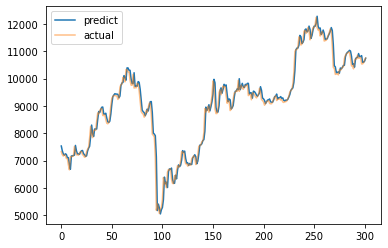

In [88]:
plt.plot(yhat_inverse, label='predict')
plt.plot(testY_inverse, label='actual', alpha=0.5)
plt.legend()
plt.show()

In [89]:
predictDates = df.tail(len(testX)).index

In [90]:
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

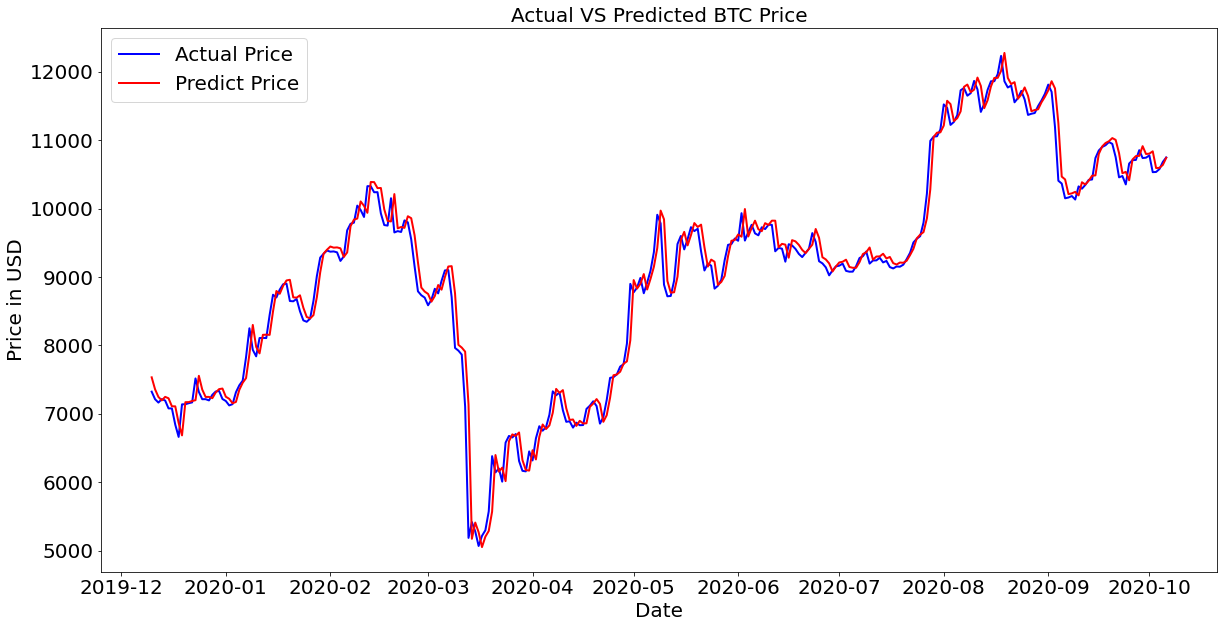

In [134]:
plt.rc('figure', figsize=(20, 10))
fig, ax = plt.subplots()
ax.plot(predictDates, testY_reshape, c='blue',label= 'Actual Price',linewidth=2)
ax.plot(predictDates, yhat_reshape, c='r',label= 'Predict Price',linewidth=2)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.title('Actual VS Predicted BTC Price',fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.ylabel('Price in USD',fontsize=20)
plt.legend(prop={'size': 20})
plt.show()

# import seaborn as sns

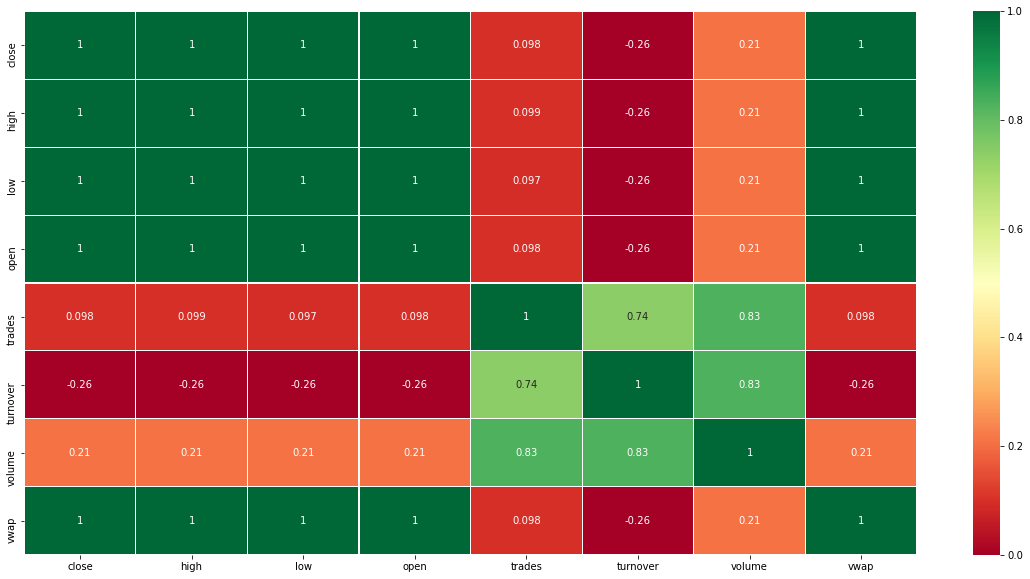

In [97]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)

In [110]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        print(names)
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [99]:
df.head()

,close,high,low,open,trades,turnover,volume,vwap
date,,,,,,,,
2018-01-01,13541.366319,13557.984028,13524.845139,13541.872917,151.901389,3.191650e+09,430376.524306,13542.399306
2018-01-02,13618.049306,13632.106597,13602.637153,13616.986458,173.356250,3.991163e+09,547527.584028,13618.215833
2018-01-03,14993.412500,15009.243750,14977.330556,14993.340278,188.893056,4.238429e+09,635719.903472,14994.467292
2018-01-04,14846.844444,14859.795139,14833.456944,14846.855556,158.861806,3.806899e+09,564605.880556,14847.653750
2018-01-05,15463.361806,15476.509722,15449.327083,15462.259028,164.459028,3.995719e+09,624329.748611,15464.094653


In [100]:
values = df[['vwap'] + ['trades'] + ['volume']].values

values = values.astype('float32')

In [101]:
values

array([[1.3542399e+04, 1.5190138e+02, 4.3037653e+05],
       [1.3618216e+04, 1.7335625e+02, 5.4752756e+05],
       [1.4994468e+04, 1.8889305e+02, 6.3571988e+05],
       ...,
       [1.0580353e+04, 8.4100693e+01, 3.1150050e+05],
       [1.0684435e+04, 1.0550625e+02, 4.6799416e+05],
       [1.0749759e+04, 8.1982437e+01, 3.6201200e+05]], dtype=float32)

In [102]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [107]:
scaled.shape[1]

3

In [111]:
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

['var1(t-1)', 'var2(t-1)', 'var3(t-1)']


,var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
1,0.766165,0.046291,0.028951,0.771770,0.055034,0.041588
2,0.771770,0.055034,0.041588,0.873515,0.061365,0.051102
3,0.873515,0.061365,0.051102,0.862661,0.049127,0.043430
4,0.862661,0.049127,0.043430,0.908234,0.051408,0.049873
5,0.908234,0.051408,0.049873,0.994274,0.047292,0.045616


In [183]:
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.766165   0.046291   0.028951  0.771770
2   0.771770   0.055034   0.041588  0.873515
3   0.873515   0.061365   0.051102  0.862661
4   0.862661   0.049127   0.043430  0.908234
5   0.908234   0.051408   0.049873  0.994274


In [184]:
values = reframed.values
n_train_hours = int(len(values) * 0.7)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(688, 1, 3) (688,) (296, 1, 3) (296,)


In [185]:
multi_model = Sequential()
multi_model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
multi_model.add(Dense(1))
multi_model.compile(loss='mae', optimizer='adam')
multi_history = multi_model.fit(train_X, train_y, epochs=300, batch_size=100, validation_data=(test_X, test_y), verbose=0, shuffle=False)

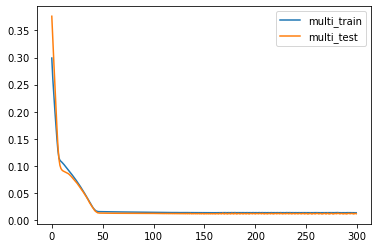

In [186]:
plt.plot(multi_history.history['loss'], label='multi_train')
plt.plot(multi_history.history['val_loss'], label='multi_test')
plt.legend()
plt.show()

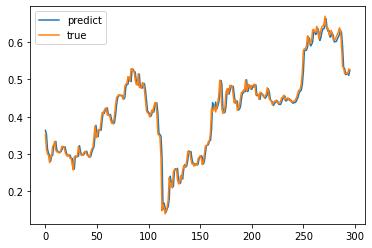

In [187]:
yhat = multi_model.predict(test_X)
plt.plot(yhat, label='predict')
plt.plot(test_y, label='true')
plt.legend()
plt.show()

In [188]:
test_X.shape[2]

3

In [189]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [190]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 249.489


In [194]:
predictDates

NameError: name 'size' is not defined

ValueError: x and y must have same first dimension, but have shapes (295,) and (296,)

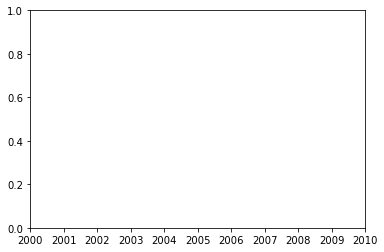

In [191]:
plt.plot(predictDates, inv_y, label= 'Actual Price')
plt.plot(predictDates, inv_yhat, lable= 'Multi Predict Price')
plot.plot(predictDates, yhat_reshape, label= 'Predict Price')

In [15]:
#sns.set(style="darkgrid")
import seaborn as sns; sns.set()

df.loc['2019':'2018']['high'].resample(rule='T').mean().plot()

TypeError: no numeric data to plot

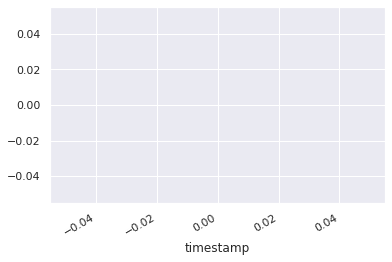

In [145]:
data1=df.loc['2017-07-02']
data1['high'].plot(style="-")
data1['high'].resample('BM').mean().plot(style=":")

In [146]:
df=df.fillna(method='ffill')

In [147]:
df.corr()

,close,high,low,open,trades,turnover,volume,vwap
close,1.000000,0.999984,0.999982,0.999974,0.102216,0.054937,0.086500,0.999993
high,0.999984,1.000000,0.999958,0.999984,0.105779,0.058402,0.090004,0.999989
low,0.999982,0.999958,1.000000,0.999974,0.098112,0.051040,0.082576,0.999989
open,0.999974,0.999984,0.999974,1.000000,0.102608,0.055556,0.087170,0.999988
trades,0.102216,0.105779,0.098112,0.102608,1.000000,0.932647,0.930092,0.101969
turnover,0.054937,0.058402,0.051040,0.055556,0.932647,1.000000,0.995718,0.054709
volume,0.086500,0.090004,0.082576,0.087170,0.930092,0.995718,1.000000,0.086277
vwap,0.999993,0.999989,0.999989,0.999988,0.101969,0.054709,0.086277,1.000000


In [16]:
import numpy
from numpy import array
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,GRU
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from pandas import Series

In [17]:
data=df['close']

In [18]:
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [19]:
numpy.random.seed(0)

# load the dataset
dataframe = data
dataset = dataframe.values
dataset = dataset.astype('float64').reshape(-1, 1)

# normalize the dataset
scaler = MinMaxScaler()
#scaler=RobustScaler()
#scaler=StandardScaler()
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

n_steps_in=3
n_steps_out=1
trainX, trainY =split_sequence(train.flatten(), n_steps_in, n_steps_out)
testX, testY = split_sequence(test.flatten(), n_steps_in, n_steps_out)


In [20]:
trainY

array([[0.37457723],
       [0.37598647],
       [0.37669109],
       ...,
       [0.27353439],
       [0.27367531],
       [0.27353439]])

In [21]:
trainX.shape,trainY.shape

((66974, 3), (66974, 1))

In [22]:
testX.shape,testY.shape

((32986, 3), (32986, 1))

In [23]:
n_features = 1
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], n_features))
testX = testX.reshape((testX.shape[0], testX.shape[1], n_features))

In [24]:
trainX.shape,trainY.shape,testX.shape,testY.shape

((66974, 3, 1), (66974, 1), (32986, 3, 1), (32986, 1))

In [25]:
from keras.layers import Activation, Dense,Dropout
model = Sequential()

model.add(LSTM(256, return_sequences=True,input_shape=(n_steps_in, n_features)))

model.add(LSTM(256))


model.add(Dense(1))
import keras
from keras import optimizers

#keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False, clipnorm=1)

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, verbose=1,shuffle=False,batch_size=50)


Epoch 1/100
1340/1340 [==============================] - 22s 17ms/step - loss: 7.8832e-04
Epoch 2/100
1340/1340 [==============================] - 23s 17ms/step - loss: 7.3147e-04
Epoch 3/100
1340/1340 [==============================] - 21s 15ms/step - loss: 0.0012
Epoch 4/100
1340/1340 [==============================] - 23s 17ms/step - loss: 0.0012
Epoch 5/100
1340/1340 [==============================] - 21s 16ms/step - loss: 0.0014
Epoch 6/100
1340/1340 [==============================] - 24s 18ms/step - loss: 0.0016
Epoch 7/100
1340/1340 [==============================] - 21s 16ms/step - loss: 0.0018
Epoch 8/100
1340/1340 [==============================] - 21s 15ms/step - loss: 0.0020
Epoch 9/100
1340/1340 [==============================] - 22s 16ms/step - loss: 0.0022
Epoch 10/100
1340/1340 [==============================] - 22s 16ms/step - loss: 0.0021
Epoch 11/100
1340/1340 [==============================] - 21s 16ms/step - loss: 0.0029
Epoch 12/100
1340/1340 [====================

In [26]:
# make predictions
trainPredict = model.predict(trainX)



In [27]:
testPredict = model.predict(testX)

In [28]:
trainPredict.shape,testPredict.shape

((66974, 1), (32986, 1))

In [29]:
def split_y_sequence(sequence, n_steps_in, n_steps_out):
    
	y = list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_y = sequence[end_ix:out_end_ix]
		
		y.append(seq_y)
	return array(y)

In [30]:
trainPredict.shape,trainY.shape,testPredict.shape,testY.shape

((66974, 1), (66974, 1), (32986, 1), (32986, 1))

In [31]:
#trainpre=split_y_sequence(trainPredict,n_steps_in=3,n_steps_out=1)

In [32]:
#testpre=split_y_sequence(testPredict,n_steps_in=3,n_steps_out=1)

In [33]:
#trp=trainpre.reshape(len(trainpre),2)
#tep=testpre.reshape(len(testpre),2)

In [34]:
testPredict.shape,testY.shape

((32986, 1), (32986, 1))

In [35]:
#trp.shape,trainY.shape

In [36]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)


In [37]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))
predictions = numpy.empty_like(dataset)
predictions[:, :] = numpy.nan
predictions[n_steps_in:len(trainPredict)+n_steps_in, :] = trainPredict
predictions[len(trainPredict)+(n_steps_in*2):len(dataset)+2, :] = testPredict
#data=pd.DataFrame(numpy.concatenate((trainPredict[0:len(trainPredict)-look_back-1],testPredict[0:len(testPredict)-look_back-1])),columns=["predicted"])
#print('one',data.count())
#print('two',dataframe.count())
predictionsDF=pd.DataFrame(predictions,columns=["predicted"],index=dataframe.index)
ans=pd.concat([dataframe,predictionsDF],axis=1)
print( ans,[n_steps_in,trainScore,testScore])

Train Score: 89.40 RMSE
Test Score: 436.10 RMSE
                             close     predicted
timestamp                                       
2020-09-11 12:36:00+05:00  10250.0           NaN
2020-09-11 12:35:00+05:00  10250.0           NaN
2020-09-11 12:34:00+05:00  10256.0           NaN
2020-09-11 12:33:00+05:00  10260.5  10193.082031
2020-09-11 12:32:00+05:00  10265.5  10195.665039
...                            ...           ...
2020-07-04 02:37:00+05:00   9083.5   9668.465820
2020-07-04 02:36:00+05:00   9084.0   9668.465820
2020-07-04 02:35:00+05:00   9083.5   9668.508789
2020-07-04 02:34:00+05:00   9084.0   9668.465820
2020-07-04 02:33:00+05:00   9083.5   9668.508789

[99966 rows x 2 columns] [3, 89.40484744335058, 436.10262088270076]
